In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

Additional imports. split_text and claim_plots are internal libraries.

In [2]:
from split_text import *
import matplotlib.pyplot as plt
from statistics import mean
from claim_plots import *

Original imports

In [3]:
import numpy as np
import pandas as pd
import json
import datetime
from tqdm import tqdm, trange
import ast
import re

import requests
import spacy
import random

from sentence_transformers import SentenceTransformer, util
import networkx as nx

from gensim.models.word2vec import Word2Vec

In [4]:
def normalize_text(text):
    text = text.replace('&amp;', '&')
    text = text.replace('\xa0', '')
    text = re.sub(r'http\S+', '', text)
    text = " ".join(text.split())
    return text

In [5]:
# df = pd.read_csv('data/birdwatch_match_dataset.csv')
df = pd.read_csv('data/birdwatch_match_dataset_edit.csv')
df

,tweetIds,tweets,claims_ind,claims
0,1233134710638825473,CDC does not currently recommend the use of fa...,0,Children have little chance of dying of COVID-...
1,1352325471539769358,@RonaldKlain Election Fraud was inevitable. De...,-1,NaN
2,1352754599590035459,Donald Trump is the first president in modern ...,-1,NaN
3,1354865702889533442,"First they came for our Free Speech, then they...",-1,NaN
4,1354948221571788813,"Yes, I want somebody to shoot Nancy Pelosi in ...",-1,NaN
...,...,...,...,...
9403,0,x,5013,On May 3 2023 65-year-old Kevin Darmody was la...
9404,0,x,5014,Some people desperately want attention and tak...
9405,0,x,5015,China has an upper middle income developing mi...
9406,0,x,5016,The Economist Intelligence Unit (EIU) is an or...


In [402]:
lines = split_file('test_text.txt', mode='s')

f = open("sentences.txt", "w")

for i in range(len(lines)):
    f.write(f'{i}\t{lines[i]}\n')

f.close()

# lines

In [403]:
out = pd.DataFrame(data=lines)
lines_ind = out.index.tolist()

In [404]:
claims_with_repetitions = df['claims'].dropna().tolist()
claims = []
for c in claims_with_repetitions:
    if not c in claims:
        claims.append(c)

claims_ind = df['claims_ind'].tolist()

In [405]:
SBmodel = SentenceTransformer('all-mpnet-base-v2')

In [406]:
emb_lines = SBmodel.encode(lines,show_progress_bar=True, batch_size=128)

emb_claims = SBmodel.encode(claims,show_progress_bar=True, batch_size=128)
# Save and load the claims embeddings model
np.save('emb_claims.npy', emb_claims)
# emb_claims = np.load('emb_claims.npy')

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [407]:
topn = 200

In [408]:
from collections import Counter
 
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

Pro každou line najít 3 top nejpodobnější claimy, vypsat si to do filu a zkontrolovat jak se opakují, jestli jsou tam shody.

In [409]:
line_similarities = []

def convert_tuple(tup):
    return ''.join([str(x) for x in tup])

for i in emb_lines:
    cos_sim = util.cos_sim(i, emb_claims)
    line_similarities.append(cos_sim)

l = []
l_for_print = []
l_indices = []
counter = 0
l_chunk_info = []

for s in line_similarities:
    v, ind = s.flatten().sort(descending=True)
    threshold = 0
    for i in range(len(claims)):
        # f = open("sim.txt", "x")
        if v[i] >= threshold:
            c = (round(v[i].item(), 3), ind[i].item(), claims[ind[i]])
            c_chunk = [round(v[i].item(), 3), ind[i].item(), claims[ind[i]]]
            content = 'Score: %s'%round(v[i].item(), 3), ' Claim: [%s] '%ind[i].item(), claims[ind[i]]
            content = convert_tuple(content)
            l_for_print.append(content)
            l.append(c)
            l_indices.append(str(counter))
            l_chunk_info.append(c_chunk)

    counter += 1

In [410]:
for i in range(len(l_chunk_info)):
    l_chunk_info[i].append(l_indices[i])

In [411]:
score_data = [[inf[1], inf[2], inf[0]] for inf in l_chunk_info]

In [412]:
chunk_data_ranks = []
for i in tqdm(range(len(lines))):
    r = [[rd[1], rd[2], rd[0], int(rd[3])] for rd in filter(lambda rd: int(rd[3]) == i, l_chunk_info)]
    
    r.sort(key=lambda x: x[2], reverse=True)
    
    for j in range(len(r)):
        r[j].append(j + 1)
        r[j].append(1 / (j + 1))
        
    # len_s = len(r)
    # # s = [s[j] if len(s) > j else 0 for j in range(len(lines_ind))]
    # txt = [rd[2] for rd in l_chunk_info if rd[3] == i]
    # ind = [rd[1] for rd in l_chunk_info if rd[3] == i]
    # chunk = [rd[3] for rd in l_chunk_info if rd[3] == i]
    # if len_s > 0:
    #     claim_data_averages.append((ind[0], txt[0], mean(s)))
    chunk_data_ranks.append(r)

100%|██████████| 58/58 [00:01<00:00, 42.21it/s]


In [413]:
claims_mrr = []

for i in tqdm(range(len(claims))):
    claim_rank_sum = 0
    for k in range(len(chunk_data_ranks)):
        if len(chunk_data_ranks[k]) == 0: continue
        claim_rank_sum += next((x[5] for x in chunk_data_ranks[k] if x[0] == i), 0)
    claims_mrr.append((i, claims[i], claim_rank_sum / len(chunk_data_ranks)))
claims_mrr_csv = pd.DataFrame(claims_mrr, columns=['CID', 'Claim', 'MRR'])
claims_mrr_csv.sort_values('MRR', ascending=False, inplace=True)
claims_mrr_csv.set_index(claims_mrr_csv.columns[0], inplace=True)

Saving the results to CSV - sentence version or paragraph version.

In [414]:
# claims_mrr_csv.to_csv('p_claims_mrr_test_text0.csv', sep=';')
# claims_mrr_csv.to_csv('s_claims_mrr_test_text0.csv', sep=';')

In [415]:
claim_data_averages = []
for i in tqdm(range(len(claims_ind))):
    s = [sd[2] for sd in filter(lambda sd: sd[0] == i, score_data)]
    len_s = len(s)
    s = [s[j] if len(s) > j else 0 for j in range(len(lines_ind))]
    txt = [sd[1] for sd in score_data if sd[0] == i]
    ind = [sd[0] for sd in score_data if sd[0] == i]
    if len_s > 0:
        claim_data_averages.append((ind[0], txt[0], mean(s)))
claim_data_averages = pd.DataFrame(claim_data_averages, columns=['CID', 'Claim', 'Score_average'])
claim_data_averages.sort_values('Score_average', ascending=False, inplace=True)
claim_data_averages.set_index(claim_data_averages.columns[0], inplace=True)

In [416]:
claim_data_max = []
for i in tqdm(range(len(claims_ind))):
    s = [sd[2] for sd in filter(lambda sd: sd[0] == i, score_data)]
    txt = [sd[1] for sd in score_data if sd[0] == i]
    ind = [sd[0] for sd in score_data if sd[0] == i]
    if len(s) > 0:
        claim_data_max.append((ind.pop(), txt.pop(), max(s)))
claim_data_max = pd.DataFrame(claim_data_max, columns=['CID', 'Claim', 'Score_max'])
claim_data_max.sort_values('Score_max', ascending=False, inplace=True)
claim_data_max.set_index(claim_data_max.columns[0], inplace=True)

100%|██████████| 9408/9408 [03:31<00:00, 44.55it/s]


Saving the results to CSV - sentence version or paragraph version.

In [417]:
# claim_data_averages.to_csv('p_averages_ranks_test_text0.csv')
# claim_data_averages.to_csv('s_averages_ranks_test_text0.csv')

In [418]:
# claim_data_max.to_csv('p_maxima_ranks_test_text0.csv')
# claim_data_max.to_csv('s_maxima_ranks_test_text0.csv')

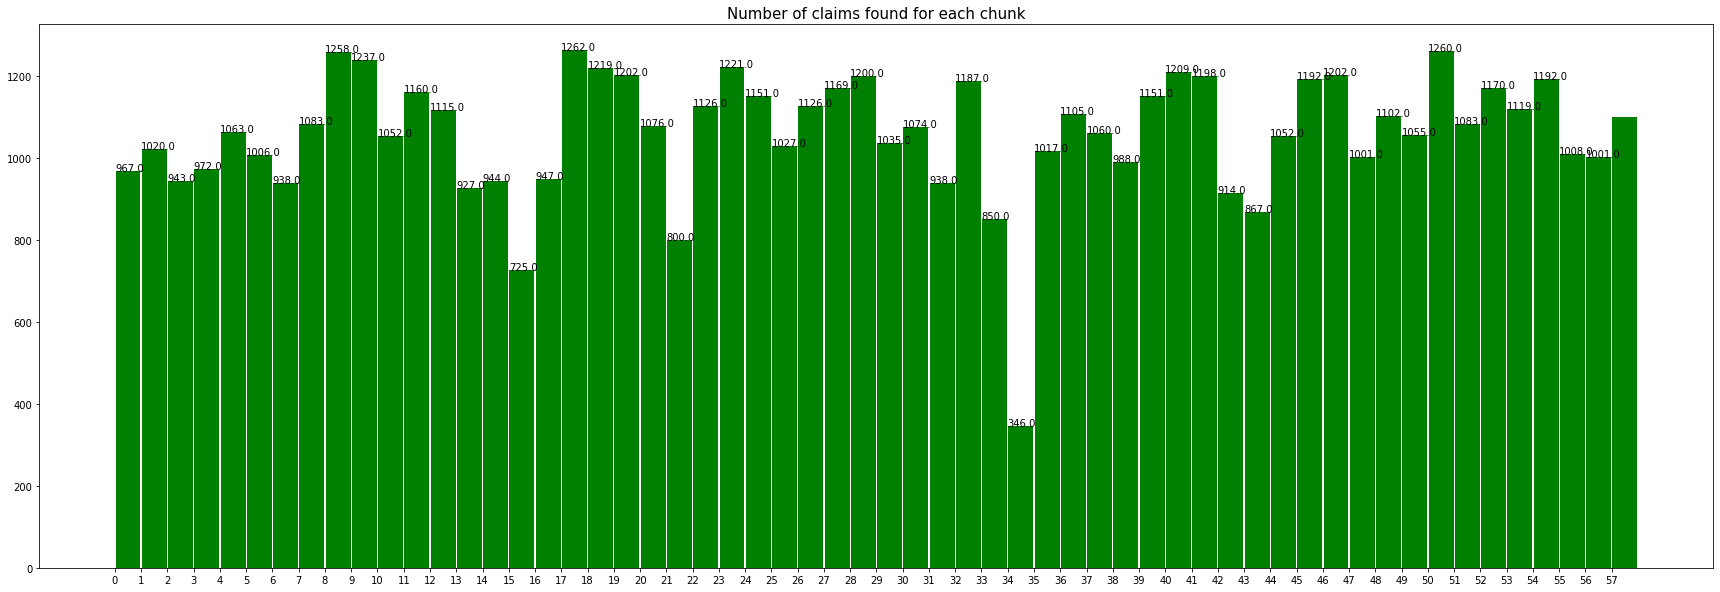

In [419]:
plot_claim_distribution(l_indices, lines_ind, save=False)

In [420]:
def get_claims_by_chunk_id(cls, chunk_id):
    return [cl for cl in cls if cl[3] == chunk_id]

In [421]:
def get_scores_by_id(scs, id):
    return [sc[1] for sc in scs if sc[0] == id]

In [422]:
def top_n_claims(lst, n):
    return sorted(lst, key=lambda x: x[0], reverse=True)[:n]

In [423]:
c_indeces = []
for i in range(len(l)):
    c_index = l[i][1]
    c_indeces.append(c_index)
    
mfq = most_frequent(c_indeces)
# print(mfq)

topn_most_frequent = []
topn_most_frequent_ind = []

for i in range(len(l)):
    if l[i][1] == mfq:
        topn_most_frequent.append((l[i][1], l[i][2]))
        topn_most_frequent_ind.append(l[i][1])
        if len(topn_most_frequent) == topn:
            break
        c_indeces = [value for value in c_indeces if value != mfq]
        mfq = most_frequent(c_indeces)
        # print(mfq)

print('Top n claims (cosine similarity):')       
for claim in range(len(topn_most_frequent)):
    print('Claim ID %s'%topn_most_frequent[claim][0],',', 'claim content: %s'%topn_most_frequent[claim][1])

scores = []
for i in range(len(l)):
    if l[i][1] in topn_most_frequent_ind:
        score = [l[i][1], l[i][0]]
        scores.append(score)
        
for i in topn_most_frequent_ind:
    scores_list = get_scores_by_id(scores, i)
    print('Average cosine similarity score for claim ID %s'%i, 'is %s.'%mean(scores_list))
    print('Max cosine similarity score for claim ID %s'%i, 'is %s.'%max(scores_list))

Top n claims (cosine similarity):
Claim ID 1034 , claim content: Says a deer became "riddled with tumors from eating plants sprayed with Monsantos Roundup."
Claim ID 389 , claim content: "The U.S. recorded its slowest economic growth in five years (2016). GDP up only 1.6%. Trade deficits hurt the economy very badly."
Claim ID 1004 , claim content: We just had two years (2016-2018) of record-breaking Global Cooling.
Claim ID 35 , claim content: The Biden administration had to "start from scratch" with a comprehensive COVID-19 vaccine distribution plan because the Trump administration had no working plan.
Claim ID 1226 , claim content: "We have spent $350 million to deal with sea-level rise" in the Miami area and "hundreds of millions of dollars to deal with coral reefs."
Claim ID 879 , claim content: "Our country has succeeded in reducing greenhouse emissions in previous years."
Claim ID 302 , claim content: claims a vaccine against the novel coronavirus has been used on American cattle

In [424]:
w = create_y_matrix(topn_most_frequent_ind, l_chunk_info, lines_ind)

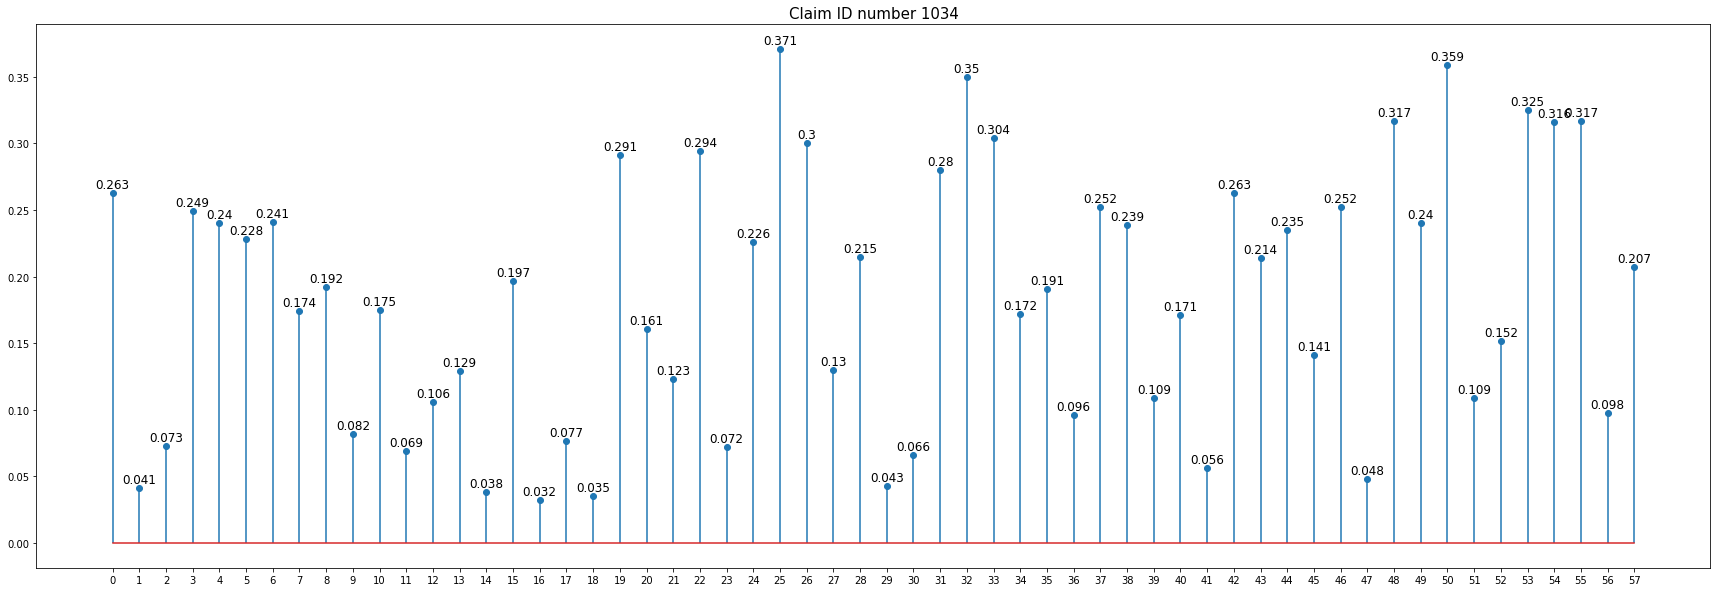

In [425]:
plot_claim_appearances(w[0], lines_ind, topn_most_frequent_ind[0], save=False)

In [426]:
# claim_id = 1240
# 
# data = [(int(ci[3]), ci[0]) for ci in filter(lambda ci: ci[1] == claim_id, l_chunk_info)]
# 
# for i in range(len(lines_ind)):
#     if not any(filter(lambda d: d[0] == i, data)):
#         data.append((i, 0))
# 
# data = sorted(data, key=lambda d: d[0])
# 
# y = [d[1] for d in data]

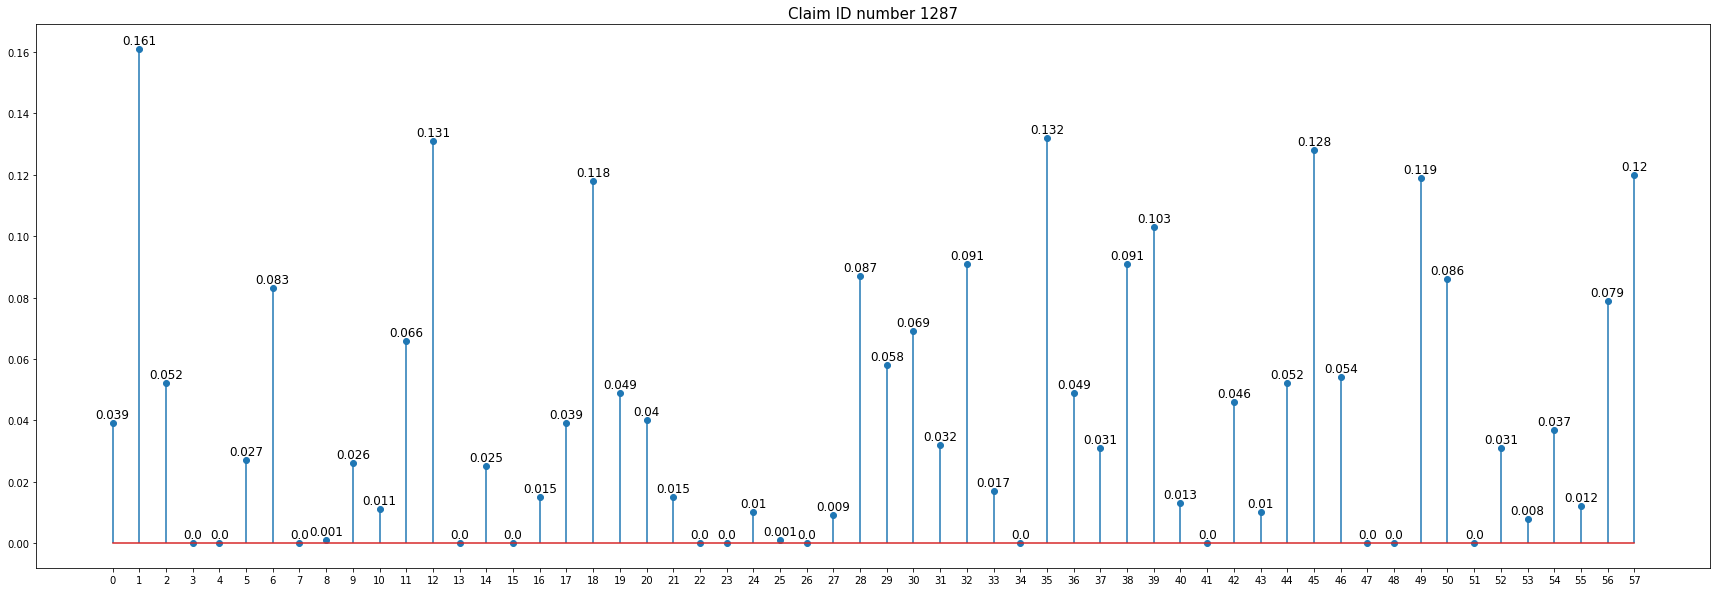

In [427]:
claim_id = 1287
y_values = get_scores_from_claim_id(claim_id, l_chunk_info, lines_ind)
plot_claim_appearances(y_values, lines_ind, claim_id, save=False)

In [428]:
claim_id = topn_most_frequent_ind[0]

data = [(int(ci[3]), ci[0]) for ci in filter(lambda ci: ci[1] == claim_id, l_chunk_info)]

for i in range(len(lines_ind)):
    if not any(filter(lambda d: d[0] == i, data)):
        data.append((i, 0))

data = sorted(data, key=lambda d: d[0])

x1 = [d[0] - 0.25 for d in data]
y1 = [d[1] for d in data]

In [429]:
claim_id = topn_most_frequent_ind[1]

data = [(int(ci[3]), ci[0]) for ci in filter(lambda ci: ci[1] == claim_id, l_chunk_info)]

for i in range(len(lines_ind)):
    if not any(filter(lambda d: d[0] == i, data)):
        data.append((i, 0))

data = sorted(data, key=lambda d: d[0])

x2 = [d[0] for d in data]
y2 = [d[1] for d in data]

In [430]:
claim_id = topn_most_frequent_ind[2]

data = [(int(ci[3]), ci[0]) for ci in filter(lambda ci: ci[1] == claim_id, l_chunk_info)]

for i in range(len(lines_ind)):
    if not any(filter(lambda d: d[0] == i, data)):
        data.append((i, 0))

data = sorted(data, key=lambda d: d[0])

x3 = [d[0] + 0.25 for d in data]
y3 = [d[1] for d in data]

([<matplotlib.axis.XTick at 0x17cae8ed100>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 0, '35'),
  Text(36, 0, '36'),
  Text(37, 0, '37'),
  Text(38, 0, '38'),
  Text(39, 0, '39'),
  Text(40, 0, '40'),
  Text(41, 0, '41'),
  Text(42, 0, '42'),
  Text(43, 0, '43'),
  Text(44, 0, '44'),
  Text(45, 0, '45'),
  Text(46,

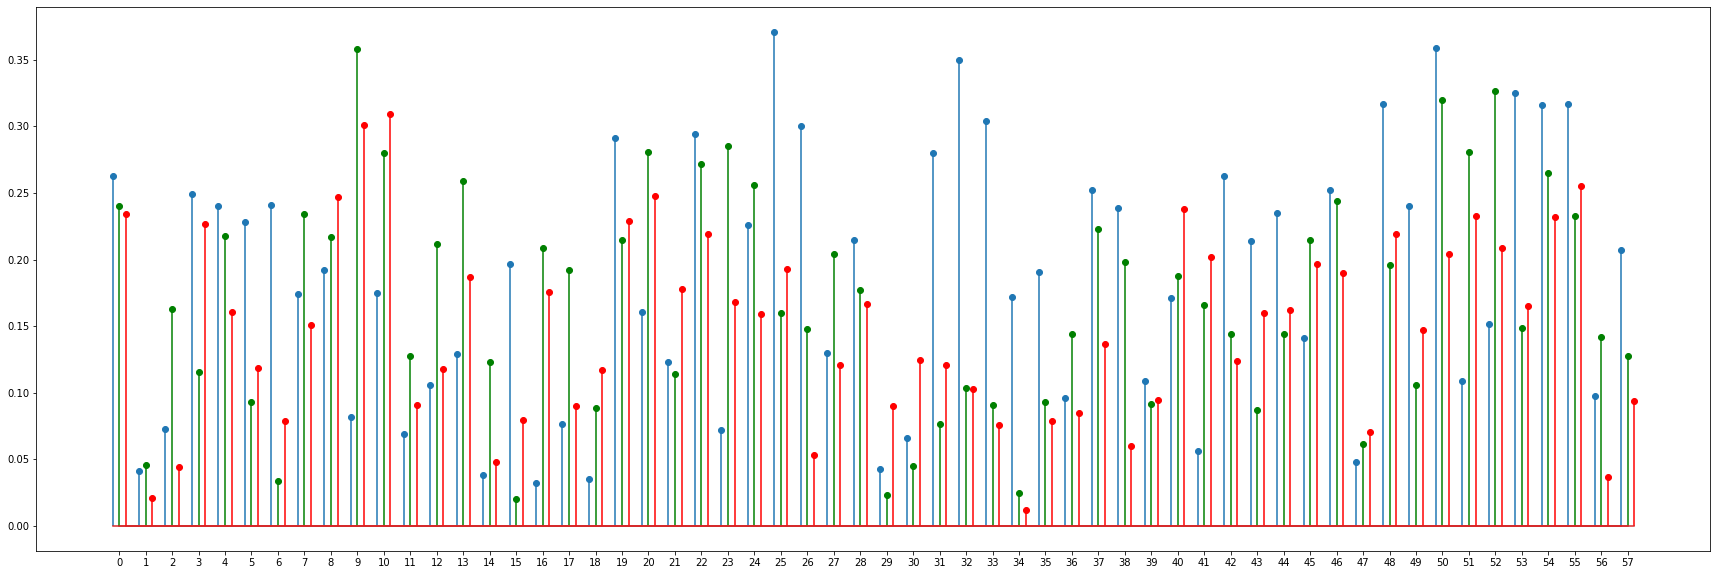

In [431]:
plt.figure(figsize=(30, 10))

plt.stem(x1, y1)
plt.stem(x2, y2, 'g')
plt.stem(x3, y3, 'r')
plt.xticks(x2)
# for _x,_y in zip(x1, y1):
#     plt.annotate(_y, xy=(_x,_y), xytext=(0,5), textcoords='offset points',ha='center', fontsize=12)
# for _x,_y in zip(x2, y2):
#     plt.annotate(_y, xy=(_x,_y), xytext=(0,5), textcoords='offset points',ha='center', fontsize=12)
# for _x,_y in zip(x3, y3):
#     plt.annotate(_y, xy=(_x,_y), xytext=(0,5), textcoords='offset points',ha='center', fontsize=12)
# plt.savefig('claim-group.png')

In [432]:
chunks = {}
unique_indices = pd.Series(l_indices).drop_duplicates().tolist()
for i in unique_indices:
    chunks_info = get_claims_by_chunk_id(l_chunk_info, i)
    chunks[i] = chunks_info

In [433]:
for k in chunks.keys():
    _scores = []
    print('Chunk number ' + k + ':')
    for item in chunks[k]:
        _scores.append((item[0], item[1], item[2]))
        c = top_n_claims(_scores, topn)
    for content in c:
        print('Cosine similarity score for claim ID %s'%content[1], '[%s]'%content[2], 'is %s.'%content[0])
    print('\n')

Chunk number 0:
Cosine similarity score for claim ID 1270 [Vertical farming is a revolutionary approach to agriculture that defies convention by growing crops on vertical surfaces.] is 0.589.
Cosine similarity score for claim ID 1240 [National Geographic covered farmers protest on their cover page.] is 0.375.
Cosine similarity score for claim ID 520 [Green energy technologies like wind and solar are the cause of rolling blackouts in Texas and other states hit by the February cold-snap.] is 0.287.
Cosine similarity score for claim ID 691 [A post links an image of vegan food products left on otherwise emptied supermarket shelves to the COVID-19 outbreak.] is 0.286.
Cosine similarity score for claim ID 1034 [Says a deer became "riddled with tumors from eating plants sprayed with Monsantos Roundup."] is 0.263.
Cosine similarity score for claim ID 2 [Germany"s green energy networks failed during a winter cold spell, with solar panels and wind turbines not working as they were blanketed in i

In [434]:
# Top n per document
sorted_chunk_info = sorted(l_chunk_info, key=lambda x: x[0], reverse=True)
top_n_chunk_info = []
top_n_claim_ids = []
print('Top n claims for document with highest cosine similarity across all chunks:')
for i in range(len(sorted_chunk_info)):
    claim_id = sorted_chunk_info[i][1]
    if claim_id in top_n_claim_ids:
        continue
    top_n_claim_ids.append(claim_id)
    top_n_chunk_info.append(sorted_chunk_info[i])
    if len(top_n_claim_ids) == topn:
        break
for info in top_n_chunk_info:
    print('Cosine similarity score for claim ID %s'%info[1], '[%s]'%info[2], 'is %s.'%info[0], 'associated with chunk number %s.'%info[3])

Top n claims for document with highest cosine similarity across all chunks:
Cosine similarity score for claim ID 1270 [Vertical farming is a revolutionary approach to agriculture that defies convention by growing crops on vertical surfaces.] is 0.663. associated with chunk number 43.
Cosine similarity score for claim ID 373 [This is on the Keystone pipelineA lot of jobs, 28,000 jobs. Great construction jobs.] is 0.517. associated with chunk number 28.
Cosine similarity score for claim ID 691 [A post links an image of vegan food products left on otherwise emptied supermarket shelves to the COVID-19 outbreak.] is 0.51. associated with chunk number 50.
Cosine similarity score for claim ID 1240 [National Geographic covered farmers protest on their cover page.] is 0.477. associated with chunk number 53.
Cosine similarity score for claim ID 1193 [The Keystone pipeline was in Phase 4 & just about completed; it"s paid for, & Biden pulls the plug.] is 0.47. associated with chunk number 28.
Cosi

In [435]:
# mean_chunk_scores = {}
mean_chunk_scores = []
for chunk_id in lines_ind:
# chunk_id = 8
    data = [(int(chi[3]), chi[0]) for chi in filter(lambda chi: int(chi[3]) == chunk_id, l_chunk_info)]

    for i in range(len(lines_ind)):
        if not any(filter(lambda d: d[0] == i, data)):
            data.append((i, 0))

    data = sorted(data, key=lambda d: d[0])

# x = [d[0] for d in data]
    y = [d[1] for d in data]
    y_mean = round(mean(y),4)
    mean_chunk_scores.append(y_mean)
    # mean_chunk_scores.update({chunk_id: y_mean})

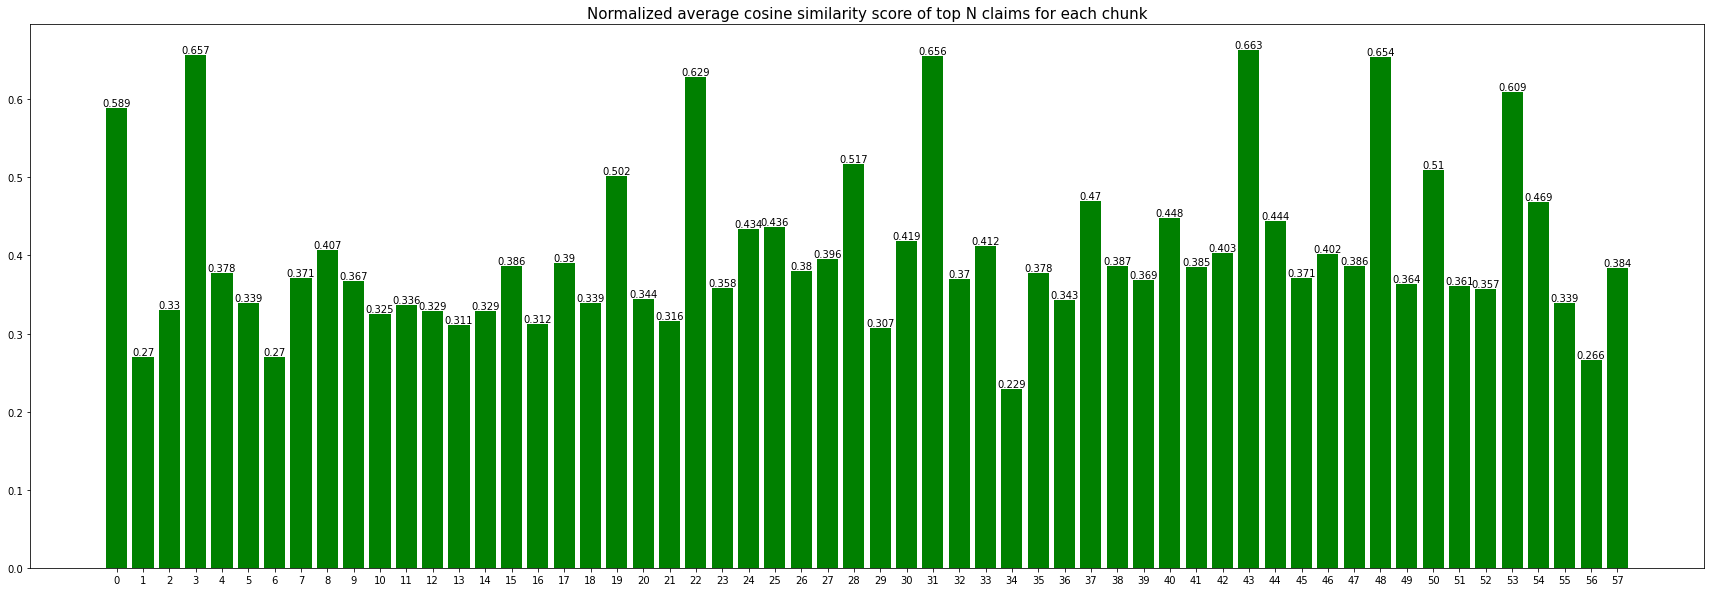

In [436]:
plot_average_chunk_scores(lines_ind, l_chunk_info, topn=1, save=False)

In [437]:
# len(lines_indeces)
# len(l)
# content_matrix = np.column_stack((lines_indeces, l))
f = open("sim.txt", "w")
# for row in content_matrix:
#     f.write(f'{row[0]}\t{row[1]}\n')

for i in range(len(l)):
    # f.write(f'{lines_indeces[i]}\t{l[i]}\n')
    f.write(f'{l_indices[i]}\t{l_for_print[i]}\n')

f.close()